In [1]:
from joblib import dump
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
torch.manual_seed(42)
test_dataset_ratio = 0.2
document_size = 50
batch_size = 256
lr = 0.001

In [3]:
topic_list = ['交易', '学业', '情感', '求职', '随写']
topic_translation = {
    '交易': 'Trading',
    '学业': 'Academics',
    '情感': 'Emotions',
    '求职': 'Job Hunting',
    '随写': 'Random Thoughts'
}

In [4]:
df = pd.DataFrame()
for i in range(document_size):
    df = pd.concat([df, pd.read_parquet(f'datasets/post_data_{i}.parquet')], ignore_index=True)
    print(f'Dataset {i} Loaded')

Dataset 0 Loaded
Dataset 1 Loaded
Dataset 2 Loaded
Dataset 3 Loaded
Dataset 4 Loaded
Dataset 5 Loaded
Dataset 6 Loaded
Dataset 7 Loaded
Dataset 8 Loaded
Dataset 9 Loaded
Dataset 10 Loaded
Dataset 11 Loaded
Dataset 12 Loaded
Dataset 13 Loaded
Dataset 14 Loaded
Dataset 15 Loaded
Dataset 16 Loaded
Dataset 17 Loaded
Dataset 18 Loaded
Dataset 19 Loaded
Dataset 20 Loaded
Dataset 21 Loaded
Dataset 22 Loaded
Dataset 23 Loaded
Dataset 24 Loaded
Dataset 25 Loaded
Dataset 26 Loaded
Dataset 27 Loaded
Dataset 28 Loaded
Dataset 29 Loaded
Dataset 30 Loaded
Dataset 31 Loaded
Dataset 32 Loaded
Dataset 33 Loaded
Dataset 34 Loaded
Dataset 35 Loaded
Dataset 36 Loaded
Dataset 37 Loaded
Dataset 38 Loaded
Dataset 39 Loaded
Dataset 40 Loaded
Dataset 41 Loaded
Dataset 42 Loaded
Dataset 43 Loaded
Dataset 44 Loaded
Dataset 45 Loaded
Dataset 46 Loaded
Dataset 47 Loaded
Dataset 48 Loaded
Dataset 49 Loaded


In [5]:
df['post_topic'].value_counts()

post_topic
树洞       159344
随写       141586
学业        88468
情感        44848
信息        29399
求职        11105
交易        10921
UNI        6110
跳蚤         5042
投票         2148
美食          760
ONE         147
公告            8
陆人计划          1
周末派对🍻         1
问卷调查          1
              1
xx            1
Name: count, dtype: int64

In [6]:
df['post_topic'] = df['post_topic'].replace('跳蚤', '交易')
df = df[df['post_topic'].isin(topic_list)]
df['post_topic_english'] = df['post_topic'].map(topic_translation)
df['post_topic_english'].value_counts()

post_topic_english
Random Thoughts    141586
Academics           88468
Emotions            44848
Trading             15963
Job Hunting         11105
Name: count, dtype: int64

In [7]:
topic_count = torch.tensor(df['post_topic'].value_counts().loc[topic_list].values)
topic_count

tensor([ 15963,  88468,  44848,  11105, 141586])

In [8]:
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['post_topic'])

In [9]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe, label_column):
        self.labels = torch.tensor(dataframe[label_column].values, dtype=torch.long)
        self.features = torch.tensor(np.stack(dataframe['embedding'].values), dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [10]:
dataset = DataFrameDataset(df, 'encoded_labels')
dataset_size = len(dataset)
test_size = int(dataset_size * test_dataset_ratio)
train_size = dataset_size - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_dataloader.__len__(), test_dataloader.__len__()

(944, 236)

In [11]:
input_dim = dataset.features.shape[1]
num_classes = len(df['encoded_labels'].unique())
input_dim, num_classes

(1536, 5)

In [12]:
matrix = df.embedding.to_numpy()
matrix = np.vstack(matrix)

In [13]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

Python(15649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


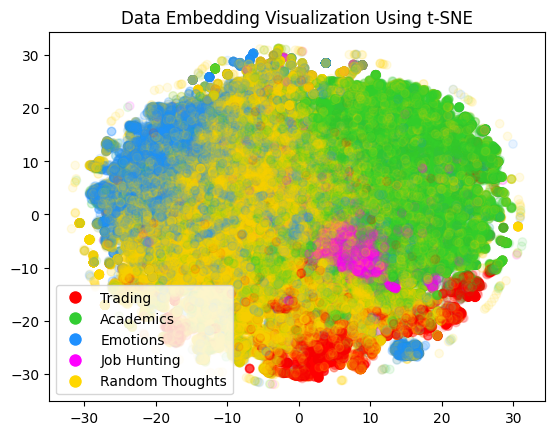

In [14]:
colors = ['red', 'limegreen', 'dodgerblue', 'magenta', 'gold']
colormap = ListedColormap(colors)
labels = [topic_translation[topic] for topic in topic_list]

x = [point[0] for point in vis_dims]
y = [point[1] for point in vis_dims]
color_indices = df.encoded_labels.values - 1
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.1)

handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, labels)]
plt.legend(handles=handles)
plt.title('Data Embedding Visualization Using t-SNE')
plt.show()

In [15]:
X_train, y_train = [], []
for batch in train_dataloader:
    features, labels = batch
    X_train.append(features)
    y_train.append(labels)
X_train = torch.cat(X_train).numpy()
y_train = torch.cat(y_train).numpy()

X_test, y_test = [], []
for batch in test_dataloader:
    features, labels = batch
    X_test.append(features)
    y_test.append(labels)
X_test = torch.cat(X_test).numpy()
y_test = torch.cat(y_test).numpy()

In [16]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train);

Random Forest Classifier Test Accuracy: 70.9027%


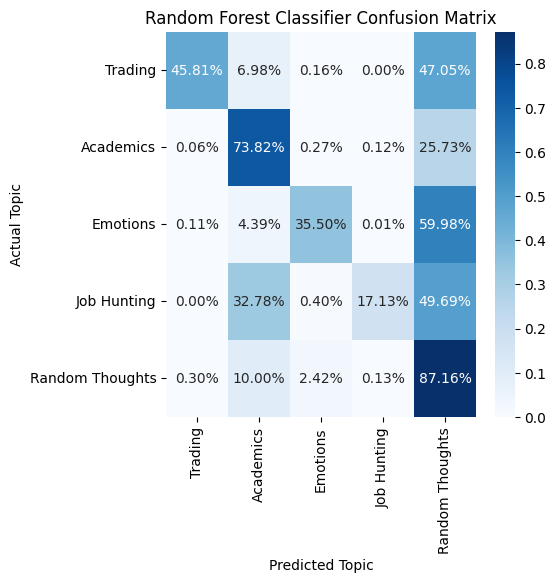

In [17]:
y_pred = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Classifier Test Accuracy: {accuracy * 100:.4f}%')

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=[topic_translation[topic] for topic in topic_list], yticklabels=[topic_translation[topic] for topic in topic_list])
plt.ylabel('Actual Topic')
plt.xlabel('Predicted Topic')
plt.title('Random Forest Classifier Confusion Matrix')
plt.show()

In [18]:
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.linear(x)

In [19]:
class ClassBalancedLoss(torch.nn.Module):
    def __init__(self, class_counts, beta=0.9999):
        super(ClassBalancedLoss, self).__init__()
        self.class_weights = self.compute_class_weights(class_counts, beta)
    
    def compute_class_weights(self, class_count, beta):
        effective_num = 1.0 - torch.pow(beta, class_count)
        weights = (1.0 - beta) / effective_num
        weights = weights / torch.sum(weights) * len(class_count)
        return weights

    def forward(self, logits, targets):
        return F.cross_entropy(logits, targets, weight=self.class_weights)

In [20]:
softmax_model = SoftmaxClassifier(input_dim, num_classes)
softmax_criterion = ClassBalancedLoss(topic_count)
softmax_optimizer = optim.Adam(softmax_model.parameters(), lr=lr)

Epoch 1, Train Loss: 1.0070, Test Loss: 0.8345
Epoch 2, Train Loss: 0.7958, Test Loss: 0.7667
Epoch 3, Train Loss: 0.7568, Test Loss: 0.7448
Epoch 4, Train Loss: 0.7408, Test Loss: 0.7335
Epoch 5, Train Loss: 0.7316, Test Loss: 0.7274
Epoch 6, Train Loss: 0.7254, Test Loss: 0.7220
Epoch 7, Train Loss: 0.7208, Test Loss: 0.7190
Epoch 8, Train Loss: 0.7173, Test Loss: 0.7162
Epoch 9, Train Loss: 0.7146, Test Loss: 0.7134
Epoch 10, Train Loss: 0.7120, Test Loss: 0.7116
Epoch 11, Train Loss: 0.7100, Test Loss: 0.7098
Epoch 12, Train Loss: 0.7083, Test Loss: 0.7092
Epoch 13, Train Loss: 0.7066, Test Loss: 0.7076
Epoch 14, Train Loss: 0.7052, Test Loss: 0.7062
Epoch 15, Train Loss: 0.7039, Test Loss: 0.7053
Epoch 16, Train Loss: 0.7028, Test Loss: 0.7046
Epoch 17, Train Loss: 0.7017, Test Loss: 0.7038
Epoch 18, Train Loss: 0.7007, Test Loss: 0.7029
Epoch 19, Train Loss: 0.6999, Test Loss: 0.7032
Epoch 20, Train Loss: 0.6990, Test Loss: 0.7016
Epoch 21, Train Loss: 0.6982, Test Loss: 0.7013
E

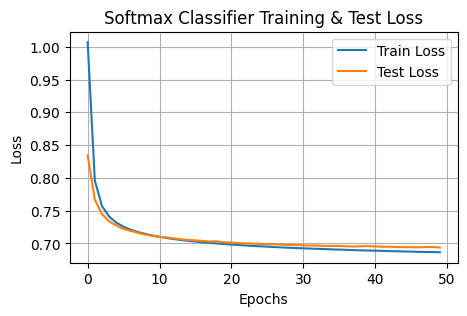

In [21]:
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    softmax_model.train()
    train_loss = 0.0
    for inputs, targets in train_dataloader:
        softmax_optimizer.zero_grad()
        outputs = softmax_model(inputs)
        loss = softmax_criterion(outputs, targets)
        loss.backward()
        softmax_optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    softmax_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = softmax_model(inputs)
            loss = softmax_criterion(outputs, targets)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    
plt.figure(figsize=(5, 3))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.title('Softmax Classifier Training & Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Softmax Classifier Test Accuracy: 74.2921%


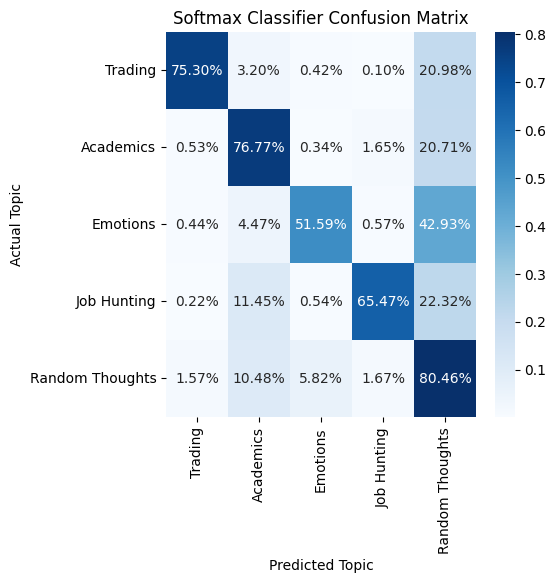

In [22]:
softmax_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for inputs, targets in test_dataloader:
        outputs = softmax_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_pred.extend(predicted.tolist())
        y_true.extend(targets.tolist())
        
print(f'Softmax Classifier Test Accuracy: {(100 * correct / total):.4f}%')

conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=[topic_translation[topic] for topic in topic_list], yticklabels=[topic_translation[topic] for topic in topic_list])
plt.ylabel('Actual Topic')
plt.xlabel('Predicted Topic')
plt.title('Softmax Classifier Confusion Matrix')
plt.show()

In [23]:
class NeuralNetworkClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(NeuralNetworkClassifier, self).__init__()
        self.linear1 = nn.Linear(input_dim, 128)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(128, 32)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.linear3 = nn.Linear(32, 16)
        self.batchnorm3 = nn.BatchNorm1d(16)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.output(x)
        return x

In [24]:
neural_network_model = NeuralNetworkClassifier(input_dim, num_classes)
neural_network_criterion = ClassBalancedLoss(topic_count)
neural_network_optimizer = optim.Adam(neural_network_model.parameters(), lr=lr)

Epoch 1, Train Loss: 0.8443, Test Loss: 0.6907
Epoch 2, Train Loss: 0.7326, Test Loss: 0.6803
Epoch 3, Train Loss: 0.7174, Test Loss: 0.6727
Epoch 4, Train Loss: 0.7071, Test Loss: 0.6694
Epoch 5, Train Loss: 0.6993, Test Loss: 0.6653
Epoch 6, Train Loss: 0.6925, Test Loss: 0.6628
Epoch 7, Train Loss: 0.6873, Test Loss: 0.6620
Epoch 8, Train Loss: 0.6821, Test Loss: 0.6589
Epoch 9, Train Loss: 0.6775, Test Loss: 0.6593
Epoch 10, Train Loss: 0.6726, Test Loss: 0.6573
Epoch 11, Train Loss: 0.6702, Test Loss: 0.6564
Epoch 12, Train Loss: 0.6649, Test Loss: 0.6571
Epoch 13, Train Loss: 0.6634, Test Loss: 0.6550
Epoch 14, Train Loss: 0.6580, Test Loss: 0.6545
Epoch 15, Train Loss: 0.6569, Test Loss: 0.6543
Epoch 16, Train Loss: 0.6533, Test Loss: 0.6535
Epoch 17, Train Loss: 0.6505, Test Loss: 0.6536
Epoch 18, Train Loss: 0.6479, Test Loss: 0.6550
Epoch 19, Train Loss: 0.6458, Test Loss: 0.6540
Epoch 20, Train Loss: 0.6418, Test Loss: 0.6546


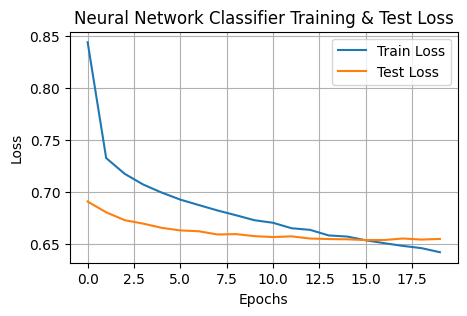

In [25]:
epochs = 20
train_losses = []
test_losses = []

for epoch in range(epochs):
    neural_network_model.train()
    train_loss = 0.0
    for inputs, targets in train_dataloader:
        neural_network_optimizer.zero_grad()
        outputs = neural_network_model(inputs)
        loss = neural_network_criterion(outputs, targets)
        loss.backward()
        neural_network_optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    neural_network_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = neural_network_model(inputs)
            loss = neural_network_criterion(outputs, targets)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    
plt.figure(figsize=(5, 3))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.title('Neural Network Classifier Training & Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Neural Network Classifier Test Accuracy: 75.7923%


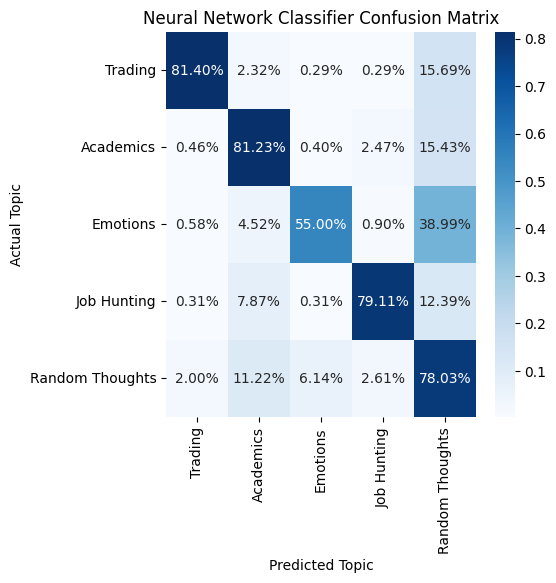

In [26]:
neural_network_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for inputs, targets in test_dataloader:
        outputs = neural_network_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_pred.extend(predicted.tolist())
        y_true.extend(targets.tolist())
        
print(f'Neural Network Classifier Test Accuracy: {(100 * correct / total):.4f}%')

conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=[topic_translation[topic] for topic in topic_list], yticklabels=[topic_translation[topic] for topic in topic_list])
plt.ylabel('Actual Topic')
plt.xlabel('Predicted Topic')
plt.title('Neural Network Classifier Confusion Matrix')
plt.show()

In [27]:
model_name = 'topic-classifier-random-forest'
dump(random_forest_model, f'models/{model_name}.joblib');

In [28]:
model_name = 'topic-classifier-softmax'
torch.save(softmax_model, f'models/{model_name}.pth')

In [29]:
model_name = 'topic-classifier-neural-network'
torch.save(neural_network_model, f'models/{model_name}.pth')